# Merge/Join Tables (VLOOKUP)

The _merge_ function mimics the functionality of JOIN in SQL queries and replaces the VLOOKUP functionality in Excel. It is one of the most powerful and useful functions for dataframes in Pandas. The main idea is to:
- **join** two (or more) dataframe table using similar keys in each of the tables. 
- **enrich** tables with loopup data  
- **validate** the match values of the key columns in the tables

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aiola-lab/from-excel-to-pandas/blob/master/notebooks/03.03_merge.ipynb)

In [4]:
import pandas as pd

## Loading lookup data

For this example, we will take one of the common lookup data, zip code. The loopup is not trivial as there are a few tousands (more than 33,000 as you can see below) of values and a simple Excel file will struggle to do it efficently and quickly. 

We will start with loading the loopup data from [Simple Maps](https://simplemaps.com/data/us-zips), which I've downloaded to a public S3 bucket.

In [1]:
url = 'https://mlguy-public.s3-eu-west-1.amazonaws.com/excel2pandas/chapter3/simplemaps_uszips_basicv1/uszips.csv'

import requests
from io import StringIO

response = requests.get(url)
response

<Response [200]>

The CSV file is read through a URL and therefore, we need to convert the text of the response to a simple string as we get when we read a local file. For that we will use the StringIO functionality as follows:

In [91]:
zip_lookup = (
    pd
    .read_csv(
        StringIO(
            response.text
        )
    )
)

zip_lookup

zip       lat        lng         city state_id   state_name  zcta  \
0        601  18.18004  -66.75218     Adjuntas       PR  Puerto Rico  True   
1        602  18.36073  -67.17517       Aguada       PR  Puerto Rico  True   
2        603  18.45439  -67.12202    Aguadilla       PR  Puerto Rico  True   
3        606  18.16724  -66.93828      Maricao       PR  Puerto Rico  True   
4        610  18.29032  -67.12243       Anasco       PR  Puerto Rico  True   
...      ...       ...        ...          ...      ...          ...   ...   
33092  99923  55.97796 -130.03671        Hyder       AK       Alaska  True   
33093  99925  55.55767 -132.97627      Klawock       AK       Alaska  True   
33094  99926  55.12617 -131.48928   Metlakatla       AK       Alaska  True   
33095  99927  56.25100 -133.37571  Point Baker       AK       Alaska  True   
33096  99929  56.36950 -131.93648     Wrangell       AK       Alaska  True   

       parent_zcta  population  density  county_fips            county_name  \
0              NaN       17242    111.4        72001               Adjuntas   
1              NaN       38442    523.5        72003                 Aguada   
2              NaN       48814    667.9        72005              Aguadilla   
3              NaN        6437     60.4        72093                Maricao   
4              NaN       27073    312.0        72011                AÃ±asco   
...            ...         ...      ...          ...                    ...   
33092          NaN          15      2.1         2198  Prince of Wales-Hyder   
33093          NaN         927      5.7         2198  Prince of Wales-Hyder   
33094          NaN        1635      4.2         2198  Prince of Wales-Hyder   
33095          NaN          38      0.2         2198  Prince of Wales-Hyder   
33096          NaN        2484      0.4         2275               Wrangell   

                                  county_weights             county_names_all  \
0                   {'72001':99.43,'72141':0.57}              Adjuntas|Utuado   
1                                  {'72003':100}                       Aguada   
2                                  {'72005':100}                    Aguadilla   
3      {'72093':94.88,'72121':1.35,'72153':3.78}  Maricao|Yauco|Sabana Grande   
4                   {'72003':0.55,'72011':99.45}               AÃ±asco|Aguada   
...                                          ...                          ...   
33092                              {'02198':100}        Prince of Wales-Hyder   
33093                              {'02198':100}        Prince of Wales-Hyder   
33094                              {'02198':100}        Prince of Wales-Hyder   
33095                              {'02198':100}        Prince of Wales-Hyder   
33096                              {'02275':100}                     Wrangell   

         county_fips_all  imprecise  military             timezone  
0            72001|72141      False     False  America/Puerto_Rico  
1                  72003      False     False  America/Puerto_Rico  
2                  72005      False     False  America/Puerto_Rico  
3      72093|72153|72121      False     False  America/Puerto_Rico  
4            72011|72003      False     False  America/Puerto_Rico  
...                  ...        ...       ...                  ...  
33092              02198      False     False        America/Sitka  
33093              02198      False     False        America/Sitka  
33094              02198      False     False   America/Metlakatla  
33095              02198      False     False        America/Sitka  
33096              02275      False     False        America/Sitka  

[33097 rows x 18 columns]

## Lookup Data Exploration

The table above shows us the type of data that we can get from enrichment based on the zip code, including city, state, latitude, longitude, population count and density.  

We can explore the values that we have in this table, before we start to use it for enrichment.

## Counting Values

The simplest aggregation function for each group is the _size_. How many zip codes do we have in each state?

In [32]:
(
    zip_lookup
    .groupby('state_name')
    .size()
)

state_name
Alabama                  642
Alaska                   238
Arizona                  405
Arkansas                 591
California              1761
Colorado                 525
Connecticut              282
Delaware                  67
District of Columbia      52
Florida                  981
Georgia                  735
Hawaii                    94
Idaho                    277
Illinois                1383
Indiana                  775
Iowa                     934
Kansas                   697
Kentucky                 767
Louisiana                515
Maine                    432
Maryland                 468
Massachusetts            537
Michigan                 986
Minnesota                884
Mississippi              423
Missouri                1022
Montana                  361
Nebraska                 581
Nevada                   175
New Hampshire            248
New Jersey               595
New Mexico               368
New York                1794
North Carolina           808
Nor

## Sorting Values

To sort the values is also simple with _sort_value()_ function, and see the population size of each state (based on the zip code lookup data):
* Start with the zip lookup data above
* Group the row by _state\_name_ and take only the _population_ values
* Sum up all the population values for each zip code area in the state Group
* Sort the states by the accumulated population value in descending order

In [33]:
us_population_distribution = (
    zip_lookup
    .groupby('state_name')['population']
    .sum()
    .sort_values(ascending=False)
)

us_population_distribution

state_name
California              39140219
Texas                   27884135
Florida                 20594164
New York                19618323
Illinois                12821487
Pennsylvania            12790950
Ohio                    11639989
Georgia                 10297534
North Carolina          10155624
Michigan                 9957465
New Jersey               8881845
Virginia                 8414042
Washington               7280023
Arizona                  6949259
Massachusetts            6830133
Tennessee                6644470
Indiana                  6637220
Missouri                 6090358
Maryland                 6003435
Wisconsin                5777892
Colorado                 5531233
Minnesota                5527473
South Carolina           4955925
Alabama                  4864630
Louisiana                4663243
Kentucky                 4446667
Oregon                   4081732
Oklahoma                 3918473
Connecticut              3581504
Puerto Rico              3384779

## Visualization of the data


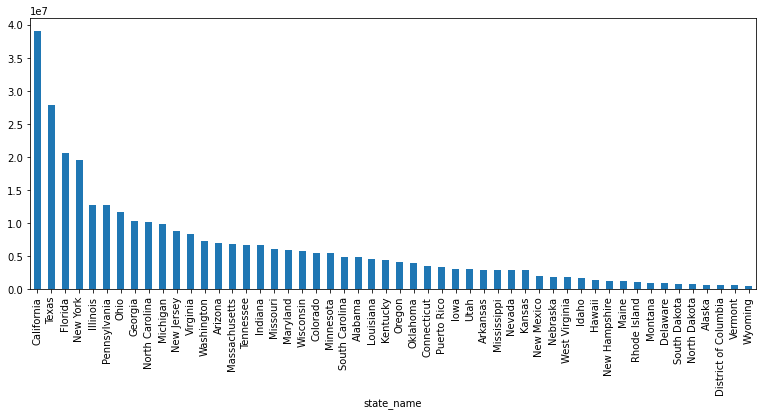

In [34]:
(
    us_population_distribution
    .plot
    .bar(figsize=(13,5))
);

## Loading the main data

We will take the data about brewries in the US that we used in one of the previous lessson, and enrich it with the data from the zip codes table. We will load it from the local file after we retried the data from the API before. 

In [106]:
breweries_data= pd.read_csv('../data/us_breweries.csv')

In [107]:
breweries_data.head()

id                      name brewery_type                     street  \
0   2       Avondale Brewing Co        micro              201 41st St S   
1  44          Trim Tab Brewing        micro             2721 5th Ave S   
2  46      Yellowhammer Brewery        micro         2600 Clinton Ave W   
3  55  Bearpaw River Brewing Co        micro  4605 E Palmer Wasilla Hwy   
4  76    King Street Brewing Co        micro           9050 King Street   

   address_2  address_3        city    state  county_province postal_code  \
0        NaN        NaN  Birmingham  Alabama              NaN  35222-1932   
1        NaN        NaN  Birmingham  Alabama              NaN  35233-3401   
2        NaN        NaN  Huntsville  Alabama              NaN  35805-3046   
3        NaN        NaN     Wasilla   Alaska              NaN  99654-7679   
4        NaN        NaN   Anchorage   Alaska              NaN       99515   

         country   longitude   latitude         phone  \
0  United States  -86.774322  33.524521  2.057775e+09   
1  United States  -86.791400  33.512849  2.057031e+09   
2  United States  -86.593201  34.727752  2.569756e+09   
3  United States -149.412710  61.575269           NaN   
4  United States -149.879076  61.138489  9.073365e+09   

                          website_url                updated_at  \
0      http://www.avondalebrewing.com  2018-08-23T23:19:57.825Z   
1       http://www.trimtabbrewing.com  2018-08-23T23:20:31.423Z   
2  http://www.yellowhammerbrewery.com  2018-08-23T23:20:33.102Z   
3      http://bearpawriverbrewing.com  2018-08-23T23:20:40.743Z   
4    http://www.kingstreetbrewing.com  2018-08-23T23:20:57.179Z   

                 created_at  
0  2018-07-24T01:32:47.255Z  
1  2018-07-24T01:32:47.815Z  
2  2018-07-24T01:32:47.838Z  
3  2018-07-24T01:32:47.967Z  
4  2018-07-24T01:32:48.301Z

We can see that the postal code is sometimes in the longer format (for example, _35222-1932_) compare to the zip codes that we have in our lookup table (for example, 35222). We will convert them to the shorter format by taking the first 5 characters ([:5]) of the string of the postal_code column.

In [108]:
breweries_data_with_zip = (
    breweries_data
    .assign(zip_code = lambda x : x.postal_code.str[:5])
)

In [109]:
breweries_data_with_zip.head()

id                      name brewery_type                     street  \
0   2       Avondale Brewing Co        micro              201 41st St S   
1  44          Trim Tab Brewing        micro             2721 5th Ave S   
2  46      Yellowhammer Brewery        micro         2600 Clinton Ave W   
3  55  Bearpaw River Brewing Co        micro  4605 E Palmer Wasilla Hwy   
4  76    King Street Brewing Co        micro           9050 King Street   

   address_2  address_3        city    state  county_province postal_code  \
0        NaN        NaN  Birmingham  Alabama              NaN  35222-1932   
1        NaN        NaN  Birmingham  Alabama              NaN  35233-3401   
2        NaN        NaN  Huntsville  Alabama              NaN  35805-3046   
3        NaN        NaN     Wasilla   Alaska              NaN  99654-7679   
4        NaN        NaN   Anchorage   Alaska              NaN       99515   

         country   longitude   latitude         phone  \
0  United States  -86.774322  33.524521  2.057775e+09   
1  United States  -86.791400  33.512849  2.057031e+09   
2  United States  -86.593201  34.727752  2.569756e+09   
3  United States -149.412710  61.575269           NaN   
4  United States -149.879076  61.138489  9.073365e+09   

                          website_url                updated_at  \
0      http://www.avondalebrewing.com  2018-08-23T23:19:57.825Z   
1       http://www.trimtabbrewing.com  2018-08-23T23:20:31.423Z   
2  http://www.yellowhammerbrewery.com  2018-08-23T23:20:33.102Z   
3      http://bearpawriverbrewing.com  2018-08-23T23:20:40.743Z   
4    http://www.kingstreetbrewing.com  2018-08-23T23:20:57.179Z   

                 created_at zip_code  
0  2018-07-24T01:32:47.255Z    35222  
1  2018-07-24T01:32:47.815Z    35233  
2  2018-07-24T01:32:47.838Z    35805  
3  2018-07-24T01:32:47.967Z    99654  
4  2018-07-24T01:32:48.301Z    99515

## Joining the tables

The joining of the table is based on a joined key. In this case we want to use the 5-digits zip code as the lookup or join key. In the previous step with shorten the longer zip codes to the shorter 5 digits format, and now we will make sure that the lookup table also have it in the same format. 
* Start with the zip loopup table
* Add a column zip_code that is based on the value of the column _zip_
* Convert the numeric value into string (_astype(str)_), 
* Pad the string with zeros when the number is shorter than 5 digits (_zfill(5)_).

In [124]:
zip_lookup_as_string = (
    zip_lookup
    .assign(
        zip_code = lambda x : x.zip
        .astype(str)
        .str
        .zfill(5)
    )
)

The join itself is simple. 
* Start with the breweries table that you want to enrich 
* Join using _merge_ with the second zip loopup table 
* Define the key column with the same name (zip_code), and we use it using the _on_ argument
* Lastly, we want to have all breweries, even if we don't find the zip code in the lookup table. Therefore, we are using _LEFT_ join using the _how_ argument. 

In [111]:
enriched_breweries_data = (
    breweries_data_with_zip
    .merge(
        zip_lookup_as_string, 
        on='zip_code', 
        how='left'
    )
)

We have now many more columns as all the columns of both tables are joined to the enriched table. We will ask the Jupyter notebook to show us all the columns by removing the default maximum number of columns to display. 

In the table below we can see all the columns. If the same column name is found in both tables and it wasn't the column that was used for the join or merge, the column of first ("left") table will be appended with x (city_x, for example), and the column of the second ("right") table will be appended with y (city_y, for example).

In [112]:
pd.set_option('display.max_columns', None)
enriched_breweries_data

id                             name brewery_type  \
0       2              Avondale Brewing Co        micro   
1      44                 Trim Tab Brewing        micro   
2      46             Yellowhammer Brewery        micro   
3      55         Bearpaw River Brewing Co        micro   
4      76           King Street Brewing Co        micro   
...   ...                              ...          ...   
7445  345  Barrel Brothers Brewing Company        micro   
7446  352            Bay Bridge Brewing Co        micro   
7447  367             Benchmark Brewing Co        micro   
7448  477             Chino Valley Brewery        micro   
7449  509             Crooked Goat Brewing        micro   

                            street  address_2  address_3       city_x  \
0                    201 41st St S        NaN        NaN   Birmingham   
1                   2721 5th Ave S        NaN        NaN   Birmingham   
2               2600 Clinton Ave W        NaN        NaN   Huntsville   
3        4605 E Palmer Wasilla Hwy        NaN        NaN      Wasilla   
4                 9050 King Street        NaN        NaN    Anchorage   
...                            ...        ...        ...          ...   
7445  399 Business Park Ct Ste 506        NaN        NaN      Windsor   
7446           688 Marsat Ct Ste B        NaN        NaN  Chula Vista   
7447      6190 Fairmount Ave Ste G        NaN        NaN    San Diego   
7448   1609 E. Grove Ave, Unit 109        NaN        NaN      Ontario   
7449         120 Morris St Ste 120        NaN        NaN   Sebastopol   

           state  county_province postal_code        country   longitude  \
0        Alabama              NaN  35222-1932  United States  -86.774322   
1        Alabama              NaN  35233-3401  United States  -86.791400   
2        Alabama              NaN  35805-3046  United States  -86.593201   
3         Alaska              NaN  99654-7679  United States -149.412710   
4         Alaska              NaN       99515  United States -149.879076   
...          ...              ...         ...            ...         ...   
7445  California              NaN  95492-6652  United States         NaN   
7446  California              NaN  91911-4697  United States         NaN   
7447  California              NaN  92120-3428  United States         NaN   
7448  California              NaN  91761-5786  United States         NaN   
7449  California              NaN  95472-3867  United States         NaN   

       latitude         phone                           website_url  \
0     33.524521  2.057775e+09        http://www.avondalebrewing.com   
1     33.512849  2.057031e+09         http://www.trimtabbrewing.com   
2     34.727752  2.569756e+09    http://www.yellowhammerbrewery.com   
3     61.575269           NaN        http://bearpawriverbrewing.com   
4     61.138489  9.073365e+09      http://www.kingstreetbrewing.com   
...         ...           ...                                   ...   
7445        NaN  7.076969e+09  http://www.barrelbrothersbrewing.com   
7446        NaN  6.199347e+09       http://www.baybridgebrewing.com   
7447        NaN  6.197953e+09       http://www.benchmarkbrewing.com   
7448        NaN  9.512917e+09     http://www.chinovalleybrewery.com   
7449        NaN  7.078274e+09     http://www.crookedgoatbrewing.com   

                    updated_at                created_at zip_code      zip  \
0     2018-08-23T23:19:57.825Z  2018-07-24T01:32:47.255Z    35222  35222.0   
1     2018-08-23T23:20:31.423Z  2018-07-24T01:32:47.815Z    35233  35233.0   
2     2018-08-23T23:20:33.102Z  2018-07-24T01:32:47.838Z    35805  35805.0   
3     2018-08-23T23:20:40.743Z  2018-07-24T01:32:47.967Z    99654  99654.0   
4     2018-08-23T23:20:57.179Z  2018-07-24T01:32:48.301Z    99515  99515.0   
...                        ...                       ...      ...      ...   
7445  2018-08-11T21:35:55.480Z  2018-07-24T01:32:52.148Z    95492  95492.0   
7446  2018-08-11T21:35:55.704Z 

Now, that we have the enriched table, we can analyze the joined data and explore the different counties across the US:
* Start with the enriched breweries data above
* Group the breweries by county_name
* For each group add the State ID 
* count the number of breweries, 
* sum up the populations of each zip code area in each group
* and calculate the average population density in the county 
* Sort that list by the population size

In [113]:
(
    enriched_breweries_data
    .groupby('county_name')
    .agg(
        state=('state_id', 'min'), 
        brewry_count=('id', 'count'),
        population_sum=('population', 'sum'),
        density_average=('density', 'mean')
        )
    .sort_values(by='population_sum', ascending=False)
)

state  brewry_count  population_sum  density_average
county_name                                                     
San Diego      CA           154       6059002.0      1670.298052
Los Angeles    CA           126       4529555.0      2834.088095
Cook           IL            98       4510406.0      5011.613265
King           WA           117       3519428.0      2407.258120
Orange         CA            88       3261503.0      1574.422727
...           ...           ...             ...              ...
Clearwater     ID             1           164.0         5.800000
Koochiching    MN             1           151.0       334.400000
Harding        NM             1           139.0         0.100000
Wabasha        MN             1            88.0        29.500000
Keweenaw       MI             1            87.0         1.000000

[959 rows x 4 columns]

We can see that _san Diego_ is the largest county in terms of population and also a beer county with 154 different brewries in it. 

Let's change the sort key to find the counties with the most breweries

In [114]:
(
    enriched_breweries_data
    .groupby('county_name')
    .agg(
        state=('state_id', 'min'), 
        brewry_count=('id', 'count'),
        population_sum=('population', 'sum'),
        density_average=('density', 'mean')
        )
    .sort_values(by='brewry_count', ascending=False)
)

state  brewry_count  population_sum  density_average
county_name                                                     
San Diego      CA           154       6059002.0      1670.298052
Los Angeles    CA           126       4529555.0      2834.088095
King           WA           117       3519428.0      2407.258120
Cook           IL            98       4510406.0      5011.613265
Jefferson      AL            93       1951501.0       770.348387
...           ...           ...             ...              ...
Flagler        FL             1         43813.0       247.300000
Fond du Lac    WI             1         10579.0        37.900000
Pitkin         CO             1         10653.0         8.900000
Pine           MN             1          9609.0        21.600000
Accomack       VA             1          2899.0        58.800000

[959 rows x 4 columns]

If you remember the map of the US that we saw in the previous section, it is now more clear the Cook county in IL is likely the dark area we saw in our hexbin visualization of the data, as a dense population of breweries. 

We can now ask ourselves where do we have the most brewries per population and add this column to our table

In [115]:
(
    enriched_breweries_data
    .groupby('county_name')
    .agg(
        state=('state_id', 'min'), 
        brewry_count=('id', 'count'),
        population_sum=('population', 'sum'),
        density_average=('density', 'mean')
        )
    .assign(brewry_per_population = lambda x : x.brewry_count / x.population_sum * 1000)
    .sort_values(by='brewry_per_population', ascending=False)
)

state  brewry_count  population_sum  density_average  \
county_name                                                        
Keweenaw       MI             1            87.0         1.000000   
Wabasha        MN             1            88.0        29.500000   
Harding        NM             1           139.0         0.100000   
Koochiching    MN             1           151.0       334.400000   
Clearwater     ID             1           164.0         5.800000   
...           ...           ...             ...              ...   
Cabarrus       NC             5        299927.0       256.800000   
Fort Bend      TX             6        371516.0       472.583333   
Chesapeake     VA             1         65603.0       155.100000   
Guadalupe      TX             7        494106.0       113.828571   
Hidalgo        TX             4        287487.0       798.050000   

             brewry_per_population  
county_name                         
Keweenaw                 11.494253  
Wabasha                  11.363636  
Harding                   7.194245  
Koochiching               6.622517  
Clearwater                6.097561  
...                            ...  
Cabarrus                  0.016671  
Fort Bend                 0.016150  
Chesapeake                0.015243  
Guadalupe                 0.014167  
Hidalgo                   0.013914  

[959 rows x 5 columns]

We can see, as it is often the case, that we have on the top and the bottom of the table counties with very few brewries. The top of the table of brewries per 1000 people is held by Keweenaw that was last on our previous table of counties by population. To avoid this, we can filter (using _query_) our table to counties that have more than 5 brewries.

In [123]:
(
    enriched_breweries_data
    .groupby('county_name')
    .agg(
        state=('state_id', 'min'), 
        brewry_count=('id', 'count'),
        population_sum=('population', 'sum'),
        density_average=('density', 'mean')
        )
    .assign(brewry_per_population = lambda x : x.brewry_count / x.population_sum * 1000)
    .query("brewry_count > 5")
    .sort_values(by='brewry_per_population', ascending=False)
)

state  brewry_count  population_sum  density_average  \
county_name                                                        
Schuyler       NY             7         15117.0        26.285714   
Grafton        NH             7         25969.0        28.714286   
Windsor        VT             7         28073.0        36.228571   
Waldo          ME             7         28697.0        28.357143   
Grand          CO             7         30992.0         3.485714   
...           ...           ...             ...              ...   
St. Charles    MO             7        356115.0       426.171429   
Kings          CA            30       1706298.0     14137.416667   
Gwinnett       GA             6        349573.0       737.716667   
Fort Bend      TX             6        371516.0       472.583333   
Guadalupe      TX             7        494106.0       113.828571   

             brewry_per_population  
county_name                         
Schuyler                  0.463055  
Grafton                   0.269552  
Windsor                   0.249350  
Waldo                     0.243928  
Grand                     0.225865  
...                            ...  
St. Charles               0.019657  
Kings                     0.017582  
Gwinnett                  0.017164  
Fort Bend                 0.016150  
Guadalupe                 0.014167  

[299 rows x 5 columns]

And the winner is Schuyler county in New York, with 7 brewries and a 0.46 brewry for every 1,000 people

## Geographic Mapping

The merge that we did allows us now to have geo location information for all the breweries, including the ones that didn't have it in the original data set, as we have the geo location of the zip code area.  

We can also add layers on real maps using the library GeoPandas. Let's start with installing the library to our environment. 

In [127]:
pip install geopandas

     |████████████████████████████████| 962 kB 1.2 MB/s 
     |████████████████████████████████| 7.4 MB 7.4 MB/s 
     |████████████████████████████████| 1.0 MB 7.9 MB/s 
     |████████████████████████████████| 14.8 MB 5.2 MB/s 
Note: you may need to restart the kernel to use updated packages.


We also need to install a library to handle geo coordinates

In [132]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


We will import the library

In [159]:
import geopandas

* Create a data frame that is designed for geo data
* Start with the enriched breweries data above
* Define the geometry of the data from 
* x as the longitude (_lng_ column)
* y as the latitude (_lat_ column)

In [160]:
gdf = (
    geopandas
    .GeoDataFrame(
    enriched_breweries_data, 
    geometry=geopandas
    .points_from_xy(
        enriched_breweries_data.lng, 
        enriched_breweries_data.lat)
    )
)

Create a geo dataframe for the world map from the built-in dataset of GeoPandas library

In [161]:
world = (
    geopandas
    .read_file(
        geopandas
        .datasets
        .get_path('naturalearth_lowres')
    )
)

* Start with the world data frame
* Filter it to use only the USA parts
* Focus on the geometry boundaries of the map
* Plot the map
* using black color
* and thin lines (0.2)
* Now, plot the breweries data 
* on the above map 
* using red dots 
* and one pixel for each

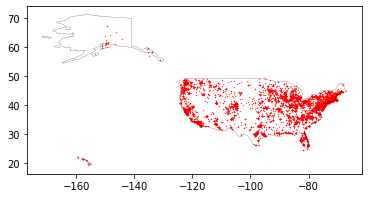

In [166]:
# We restrict to USA
ax = (
    world
    [world.iso_a3 == 'USA']
    ['geometry']
    .boundary
    .plot(
        color='black', 
        edgecolor='black', 
        linewidth=0.2
    )
)

( 
    gdf
    .plot(
        ax=ax, 
        color='red',
        markersize = 1
    )
);

This is a good start, but we can't really use it. Let's make it more usable to know where is the beer hub in the US.

* Create a 2D histogram based on the enriched breweries data 
* using x as latitude (_lat_ column),
* y as longtitude (_lng_ column),
* and 1000 bins for the histogram
* Focus only on the main land using its coordinates
* Then, create a smooth heat map from the histogram 

In [212]:
import numpy as np
from scipy import ndimage

heatmap, xedges, yedges = np.histogram2d(
    enriched_breweries_data['lat'], 
    enriched_breweries_data['lng'],
    bins=1000, 
    range=[
        [25, 50],  # North-South extent of US
        [-125, -65]  # East-West extent of US, 
    ]
)
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, 30, mode='nearest')  # smooth out peaks


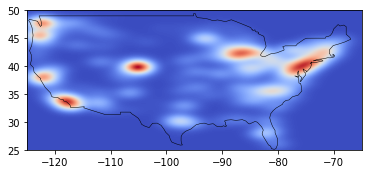

In [215]:
ax = (
    world
    [world.iso_a3 == 'USA']
    ['geometry']
    .boundary
    .plot(
        color='k', 
        edgecolor='black', 
        linewidth=0.5
    )
)

ax.imshow(logheatmap, cmap='coolwarm', extent=extent)
ax.invert_yaxis()
ax.set(xlim=[-125, -65], ylim=[25, 50]);

We can clearly see the hubs in San Diego, New York, Illinois, and another one in Colorado.